## Figure of Merit Prototype for Section 4.3: Detection of pre-SN variability for Galactic Supernova science case ##

** 2016-01-30 (WIC): ** Read in previously-computed metrics and combine their values to come up with a prototype figure of merit for the "Galactic Supernova" science case. 

Making the assumption that a core-collapse supernova would be detected directly by neutrino experiments, triggering intensive followup at all wavelengths, I adopt the detectability of an $\sim$ 8 mag nova-like outburst *before* the supernova (parameters similar to SN2010mc; Ofek et al. 2013 Nature) as a figure of merit for LSST's contribution to this science. 

I assume that the probability of a supernova going off at a given location scales with the number of stars along the line of sight (out to a fiducial distance, which I set at 80 kpc to avoid much of the halo and the Magellanic Clouds in the figure of merit). Multiplying (fraction detected) $\times$ (star count) at each position then yields a rough figure of merit for the use of LSST to detect pre-Supernova variability.

**Implementation:**

I use a slightly modified version of Mike Lund's Starcounts maf_contrib module to produce the stellar density out to some fiducial distance, then use Peter Yoachim's TransientMetric to assess the fraction of *pre*-Supernova outbursts that might be detected. The intention here is to provide a simple example using pre-computed metrics into a figure of merit to provoke the community of LSST-interested Milky Way observers. 

Imports inside subsections are needed only to run the cells in those subsections.

In [ ]:
# For reference, here are the parameters used to simulate the transients:
#peaks = {'uPeak':11, 'gPeak':9, 'rPeak':8, 'iPeak':7, 'zPeak':6,'yPeak':6}
#colors = ['b','g','r','purple','y','magenta','k']
#filterNames = ['u','g','r','i','z','y']
## Timing parameters of the outbursts
#riseSlope = -2.4
#declineSlope = 0.05  # following Ofek et al. 2013
#transDuration = 80.
#peakTime = 20.

# relevant parameter for the TransientMetric:
# nPhaseCheck=20

# Additionally, all filters were used (passed as **peaks to the TransientMetric).

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import time

In [3]:
# Some colormaps we might use
import matplotlib.cm as cm

In [4]:
# Capability to load previously-computed metrics, examine them
import lsst.sims.maf.metricBundles as mb

# plotting (to help assess the results)
import lsst.sims.maf.plots as plots

/Users/clarkson/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


### Slightly modified version of the Starcounts metric ###

In [5]:
# The example CountMetric provided by Mike Lund seems to have the column indices for coords
# hardcoded (which breaks the examples I try on my setup). This version finds the co-ordinates by 
# name instead. First the imports we need:
# import numpy as np
from lsst.sims.maf.metrics import BaseMetric
from mafContrib import starcount 

In [6]:
class AsCountMetric(BaseMetric):

    """
    WIC - Lightly modified copy of Mike Lund's example StarCounts metric in sims_maf_contrib. 
    Accepts the RA, DEC column names as keyword arguments. Docstring from the original:
    
    Find the number of stars in a given field between distNear and distFar in parsecs. 
    Field centers are read from columns raCol and decCol.
    """
    
    def __init__(self,**kwargs):
        
        self.distNear=kwargs.pop('distNear', 100)
        self.distFar=kwargs.pop('distFar', 1000)
        self.raCol=kwargs.pop('raCol', 'ra')
        self.decCol=kwargs.pop('decCol', 'dec')
        super(AsCountMetric, self).__init__(col=[], **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        sliceRA = np.degrees(slicePoint[self.raCol])
        sliceDEC = np.degrees(slicePoint[self.decCol])
        return starcount.starcount(sliceRA, sliceDEC, self.distNear, self.distFar)

### Run this out to a fiducial distance ###

(This section can be ignored if the Counts metric was already computed.) We do not do plots or summary statistics, since we should be able to evaluate those later on.

In [7]:
distNear=10.
distFar = 8.0e4  # Get most of the plane but not the magellanic clouds 

In [8]:
import lsst.sims.maf.slicers as slicers

In [9]:
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

In [10]:
slicer = slicers.HealpixSlicer(nside=64)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [11]:
metricCount=AsCountMetric(distNear=distNear, distFar=distFar)
metricList = [metricCount]

In [12]:
runName1092 = 'ops2_1092'
sqlconstraintCount = 'filter = "r" & night < 1000'  # Assume everywhere visited once in three days...
bDict1092={}
for i,metric in enumerate(metricList):
    bDict1092[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraintCount, 
                                          runName=runName1092)
opsdb1092 = db.OpsimDatabase(runName1092 + '_sqlite.db')
outDir1092 = 'TestCountOnly1092'
resultsDb1092 = db.ResultsDb(outDir=outDir1092)

In [13]:
tStart = time.time()
bgroup1092 = metricBundles.MetricBundleGroup(bDict1092, opsdb1092, outDir=outDir1092, \
                                             resultsDb=resultsDb1092)
bgroup1092.runAll()
tPost1092 = time.time()
print "Time spent Counting 1092: %.3e seconds" % (tPost1092 - tStart)

Querying database with constraint filter = "r" & night < 1000
No data matching sqlconstraint filter = "r" & night < 1000
Time spent Counting 1092: 4.365e+01 seconds


In [15]:
# Ensure the output file actually got written...
! ls -l ./TestCountOnly1092/*npz

-rw-r--r--  1 clarkson  staff  1624794 Jan 11 14:34 ./TestCountOnly1092/ops2_1092_AsCount_r_HEAL.npz


In [15]:
# We will need the same counts information for enigma if we want to normalize by 
# total counts in the survey area. So let's run the above for enigma_1189 as well.
runName1189 = 'enigma_1189'
bDict1189={}
for i,metric in enumerate(metricList):
    bDict1189[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraintCount, 
                                          runName=runName1189)
opsdb1189 = db.OpsimDatabase(runName1189 + '_sqlite.db')
outDir1189 = 'TestCountOnly1189'
resultsDb1189 = db.ResultsDb(outDir=outDir1189)

tStart = time.time()
bgroup1189 = metricBundles.MetricBundleGroup(bDict1189, opsdb1189, outDir=outDir1189, \
                                             resultsDb=resultsDb1189)
bgroup1189.runAll()
tPost1189 = time.time()
print "Time spent Counting 1189: %.3e seconds" % (tPost1189 - tStart)


Querying database with constraint filter = "r" & night < 1000
No data matching sqlconstraint filter = "r" & night < 1000
Time spent Counting 1189: 4.646e+01 seconds


In [16]:
! ls ./TestCountOnly1189/enigma_1189_AsCount_r_HEAL.npz

./TestCountOnly1189/enigma_1189_AsCount_r_HEAL.npz


### Loading the pre-computed metrics: Counts and Transients ###

In [58]:
pathCount='./TestCountOnly1092/ops2_1092_AsCount_r_HEAL.npz'
pathTransient='Transients1092Like2010mc/ops2_1092_Alert_sawtooth_HEAL.npz'

In [59]:
#Initialize then load
bundleCount = mb.createEmptyMetricBundle()
bundleTrans = mb.createEmptyMetricBundle()

bundleCount.read(pathCount)
bundleTrans.read(pathTransient)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [60]:
# Set a mask for the BAD values of the transient metric
bTrans = (np.isnan(bundleTrans.metricValues)) | (bundleTrans.metricValues <= 0.)
bundleTrans.metricValues.mask[bTrans] = True

### Normalizing the counts metric for OpSim runs with different total area ###

The two runs compared, enigma_1189 and ops1092, cover different total areas. Before proceeding further, we read in the counts metric for enigma_1189 in order to compare the total number of stars.

In [61]:
# Read in the stellar density for 1189 so that we can compare the total NStars...
pathCount1189='./TestCountOnly1189/enigma_1189_AsCount_r_HEAL.npz'
bundleCount1189 = mb.createEmptyMetricBundle()
bundleCount1189.read(pathCount1189)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [62]:
# Do the comparison
nTot1092 = np.sum(bundleCount.metricValues)
nTot1189 = np.sum(bundleCount1189.metricValues)
print "Total NStars - ops2_1092: %.3e - enigma_1189 %.3e" % (nTot1092, nTot1189)

Total NStars - ops2_1092: 1.120e+12 - enigma_1189 1.121e+12


There is a difference between the total NStars (out to 80kpc) but it's on the order of 1%, even though enigma_1189 covers more of the plane exterior to the Sun. This is probably an expression of the dominance of the central regions of the Milky Way galaxy in the density model.

To express the figure of merit as a fraction of detected pre-outbursts that would be detected by LSST, we divide the density metric for each run by its own total NStars. Thus the figure of merit will take the range $0 - 1$.

### Multiply the metric value sets together for ops2_1092 ###

I think the best way to ensure that the result has all the pieces needed by maf is to create a copy of one of the metrics, then re-read the metric in. Since we don't trust negative values of the transient metric, use the mask for non-negative transient values too.

In [63]:
bundleProc = mb.createEmptyMetricBundle()
bundleProc.read(pathTransient)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [64]:
# Set the mask
bundleProc.metricValues.mask[bTrans] = True

In [65]:
# Multiply the two together, normalise by the total starcounts over the survey
bundleProc.metricValues = (bundleCount.metricValues * bundleTrans.metricValues) 
bundleProc.metricValues /= np.sum(bundleCount.metricValues)

In [66]:
bundleProc.metric.name = '(sawtooth alert) x (counts) / NStars_total'

In [67]:
FoM1092 = np.sum(bundleProc.metricValues)
print "FoM 1092: %.2e" % (FoM1092)

FoM 1092: 8.52e-01


### Multiply the two metrics together for enigma_1189 ###

In [68]:
pathCount1189='./TestCountOnly1189/enigma_1189_AsCount_r_HEAL.npz'
pathTrans1189='./Transients1189Like2010mc/enigma_1189_Alert_sawtooth_HEAL.npz'
bundleCount1189 = mb.createEmptyMetricBundle()
bundleTrans1189 = mb.createEmptyMetricBundle()

bundleCount1189.read(pathCount1189)
bundleTrans1189.read(pathTrans1189)
bTrans1189 = (np.isnan(bundleTrans1189.metricValues)) | (bundleTrans1189.metricValues <= 0.)
bundleTrans1189.metricValues.mask[bTrans1189] = True

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [69]:
# Load 1189-like metric bundle and replace its values with processed values
bundleProc1189 = mb.createEmptyMetricBundle()
bundleProc1189.read(pathTrans1189)
bundleProc1189.metricValues.mask[bTrans1189] = True

bundleProc1189.metricValues = (bundleCount1189.metricValues * bundleTrans1189.metricValues) 
bundleProc1189.metricValues /= np.sum(bundleCount1189.metricValues)
bundleProc1189.metric.name = '(sawtooth alert) x (counts) / NStars_total'

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [70]:
FoM1189 = np.sum(bundleProc1189.metricValues)
print FoM1189

0.250599198264


### Our "result:" f = (Sawtooth alert) $\times$ ($\rho_{\ast}$) for the two runs ###

In [71]:
# Print the sum total of our f.o.m. for each run
print "FOM for ops2_1092: %.3f" % (FoM1092)
print "FOM for enigma_1189: %.3f" % (FoM1189)

FOM for ops2_1092: 0.852
FOM for enigma_1189: 0.251


### Plot the processed metrics ###

In [84]:
# Same plot information as before:
plotFuncs = [plots.HealpixSkyMap(), plots.HealpixHistogram()]
plotDictProc={'logScale':True, 'cmap':cm.cubehelix_r}
bundleProc.setPlotDict(plotDictProc)
bundleProc.setPlotFuncs(plotFuncs)

plotDictProc={'logScale':True, 'cmap':cm.cubehelix_r}
bundleProc1189.setPlotDict(plotDictProc)
bundleProc1189.setPlotFuncs(plotFuncs)


Optimal bin calculation tried to make 24270 bins, returning 200
Optimal bin calculation tried to make 10055 bins, returning 200


{'Histogram': 4, 'SkyMap': 3}

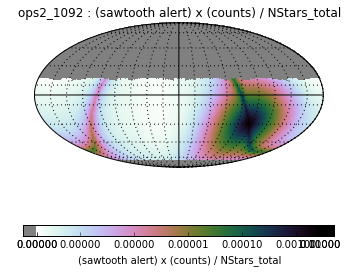

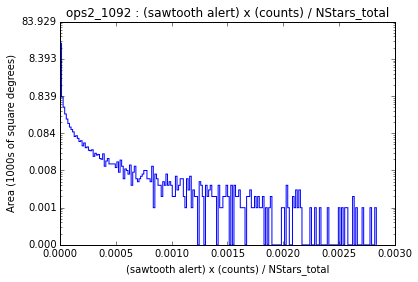

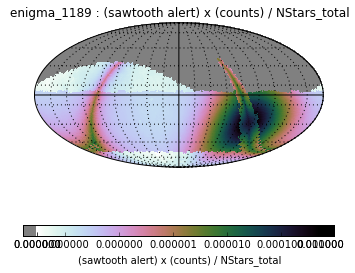

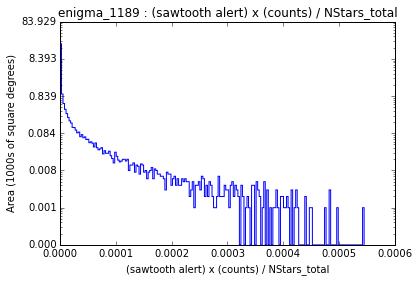

In [85]:
bundleProc.plot(savefig=True)
bundleProc1189.plot(savefig=True)

### Plot the two input metrics ###

In [74]:
# Plot just the spatial map and the histogram for the two. Use different colormaps for each.
#plotFuncs = [plots.HealpixSkyMap(), plots.HealpixHistogram()]
bundleTrans.setPlotFuncs(plotFuncs)
bundleCount.setPlotFuncs(plotFuncs)

In [75]:
# Use a different colormap for each so we can tell them apart easily...
plotDictCount={'logScale':True, 'cmap':cm.gray_r}
plotDictTrans={'logScale':False, 'cmap':cm.RdBu_r}
bundleCount.setPlotDict(plotDictCount)
bundleTrans.setPlotDict(plotDictTrans)

In [76]:
plotDictCount={'logScale':True, 'cmap':cm.gray_r}
plotDictTrans={'logScale':False, 'cmap':cm.RdBu_r}
bundleCount1189.setPlotDict(plotDictCount)
bundleTrans1189.setPlotDict(plotDictTrans)
bundleTrans1189.setPlotFuncs(plotFuncs)
bundleCount1189.setPlotFuncs(plotFuncs)

Optimal bin calculation tried to make 22894 bins, returning 200


{'Histogram': 4, 'SkyMap': 3}

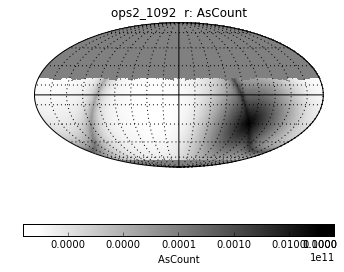

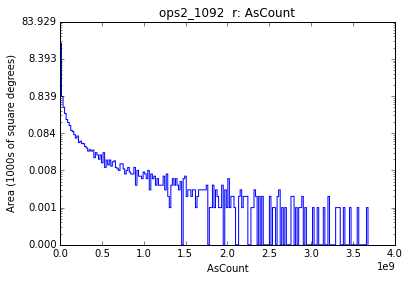

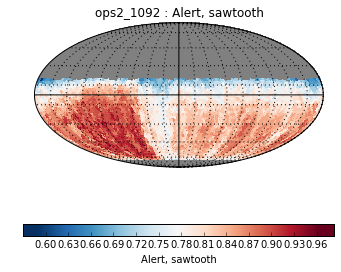

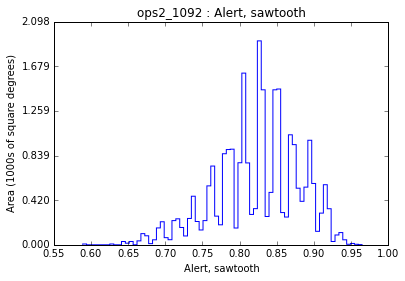

In [77]:
bundleCount.plot()
bundleTrans.plot()

Optimal bin calculation tried to make 30763 bins, returning 200


{'Histogram': 4, 'SkyMap': 3}

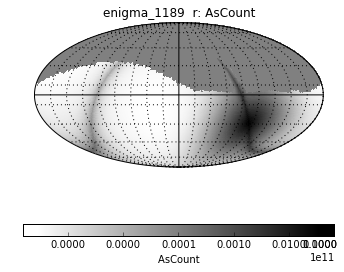

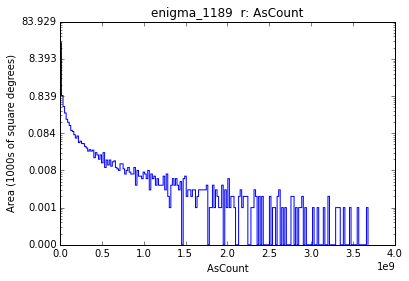

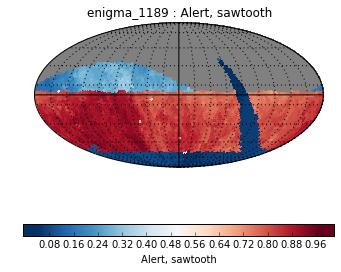

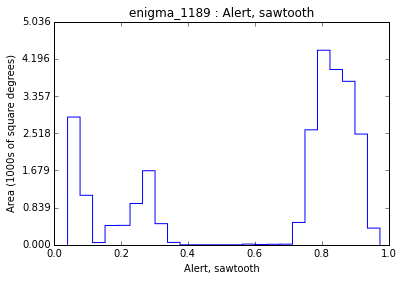

In [78]:
bundleCount1189.plot()
bundleTrans1189.plot()